In [1]:
import pandas as pd
import scipy.sparse
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import TruncatedSVD

In [2]:
class ItemBasedRecommender():
    
    def __init__(self, train_data, validation_data, test_data):
        self.train_data = train_data
        self.validation_data = validation_data
        self.test_data = test_data
        self.user_item = self.get_user_item()
        
    def get_user_item(self):
        '''Create user-item matrix from train_data.'''
        users = [user for user, items in self.train_data.items() for _ in range(len(items))]
        items = [item for items in self.train_data.values() for item in items]
        user_item = scipy.sparse.csc_matrix((np.ones(len(users)), (users, items)))
        return user_item
    
    def fit(self, components_number, save_path=False):
        '''
        Get singular value decomposition of user-item matrix.
        
        components_number -- value for reduced dimension
        save_path -- path to file to save svd-model (if False do not save)
        '''
        svd = TruncatedSVD(n_components=components_number)
        self.user_vector = svd.fit_transform(self.user_item)
        self.item_vector = svd.components_
        self.explained_variance = svd.explained_variance_ratio_.sum()
        if save_path:
            with open(save_path, 'wb') as out:
                pickle.dump(svd, out)
                
    def set_svd(self, path_to_svd):
        '''
        Load svd-model from file.
        
        path_to_svd -- path to file with svd-model
        '''
        with open(path_to_svd, 'rb') as inp:
            svd = pickle.load(inp)
        self.user_vector = svd.transform(self.user_item)
        self.item_vector = svd.components_
        self.explained_variance = svd.explained_variance_ratio_.sum() 
        
    def predict_on_items(self, items_list, predictions_number):
        '''
        Get top predictions based on list of items.
        Find mean-vector of items from list. Calculate distances between mean-vector and each item form item_vector.
        Get top items with smallest distances.
        '''
        item_mean = np.mean(self.item_vector[:, items_list], 1)
        distance = cosine_distances([item_mean], self.item_vector.T)
        recommendation = np.argsort(distance)[0]
        return recommendation[:predictions_number]
    
    def predict_for_user(self, user_id, predictions_number):
        '''Get top predictions for user.'''
        return self.predict_on_items(self.train_data[user_id], predictions_number)
    
    def predict_for_top_k_users(self, predictions_number, user_number=100, path_to_save=False):
        '''
        Get pridictions for several top users.
        
        path_to_save -- path to file to save results (if False do not save)
        '''
        recommendations = {key: [] for key in range(1, user_number + 1)}
        for user_id in range(1, user_number + 1):
            recommendations[user_id] = self.predict_for_user(user_id, predictions_number)
        if path_to_save:
            with open(path_to_save, 'wb') as out:
                pickle.dump(recommendations, out)            
        return recommendations
    
    def get_mapk(self, predicted, k=100):
        '''Get mean average precision at k in train, validation and test data.'''
        train_mapk = mapk(list(self.train_data.values()), predicted.values(), k)
        validation_mapk = mapk(list(self.validation_data.values()), predicted.values(), k)
        test_mapk = mapk(list(self.test_data.values()), predicted.values(), k)
        return train_mapk, validation_mapk, test_mapk

In [3]:
def load_data():
    with open('train_indices.pickle', 'rb') as input:
        train_indices = pickle.load(input)
    with open('test_indices.pickle', 'rb') as input:
        test_indices = pickle.load(input)
    with open('validation_indices.pickle', 'rb') as input:
        validation_indices = pickle.load(input)
        
    orders = pd.read_csv('orders.csv')[['user_id', 'order_id']]
    train_ids = orders.loc[train_indices]['order_id']
    test_ids = orders.loc[test_indices]['order_id']    
    validation_ids = orders.loc[validation_indices]['order_id']
    
    order_products_prior = pd.read_csv('order_products__prior.csv')[['product_id', 'order_id']]
    order_products_train = pd.read_csv('order_products__train.csv')[['product_id', 'order_id']]
    order_products = pd.concat([order_products_prior, order_products_train])
    orders = pd.merge(order_products, orders, on = 'order_id')
    
    orders_tmp = orders[orders['order_id'].isin(train_ids)].drop('order_id', 1).drop_duplicates()
    train_data = dict(orders_tmp.groupby('user_id')['product_id'].apply(list))
    
    orders_tmp = orders[orders['order_id'].isin(validation_ids)].drop('order_id', 1).drop_duplicates()
    validation_data = dict(orders_tmp.groupby('user_id')['product_id'].apply(list))
    
    orders_tmp = orders[orders['order_id'].isin(test_ids)].drop('order_id', 1).drop_duplicates()
    test_data = dict(orders_tmp.groupby('user_id')['product_id'].apply(list))
    
    return train_data, test_data, validation_data

In [4]:
train_data, test_data, validation_data = load_data()

In [150]:
recommender = ItemBasedRecommender(train_data, test_data, validation_data)
for comp_num in [100, 200, 500, 1000, 2000]:
    print(str(comp_num) + ' components:')
    recommender.fit(comp_num, 'svd-' + str(comp_num) + '.pickle')
    print('  explained variance = ' + str(recommender.explained_variance))
    predicted = recommender.predict_for_top_k_users(20)
    train_mapk, validation_mapk, test_mapk = recommender.get_mapk(predicted, 20)
    print('  mapk on train data ' + str(train_mapk))
    print('  mapk on validation data ' + str(validation_mapk))
    print('  mapk on test data ' + str(test_mapk))

100 components:
  explained variance = 0.18435014044214285
  mapk on train data 0.10754280829665397
  mapk on validation data 0.006820886938998394
  mapk on test data 0.03410335551384774
200 components:
  explained variance = 0.25250496388883403
  mapk on train data 0.21328698895084452
  mapk on validation data 0.00623413773189315
  mapk on test data 0.056325814984829255
500 components:
  explained variance = 0.3732448488489145
  mapk on train data 0.43267215338558124
  mapk on validation data 0.009727514862254283
  mapk on test data 0.11394629248102543
1000 components:
  explained variance = 0.4860676706008714
  mapk on train data 0.6298627669810279
  mapk on validation data 0.010525327816891283
  mapk on test data 0.12423077886807064
2000 components:
  explained variance = 0.6147765978009663
  mapk on train data 0.8154144136547943
  mapk on validation data 0.015386636963480409
  mapk on test data 0.16308892586413926


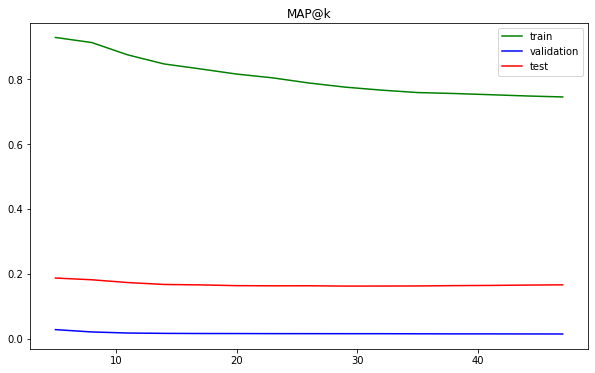

In [151]:
import matplotlib.pyplot as plt

predicted = recommender.predict_for_top_k_users(50)
train_values = []
validation_values = []
test_values = []
for k in range(5, 50, 3):
    train_mapk, validation_mapk, test_mapk = recommender.get_mapk(predicted, k)
    train_values.append(train_mapk)
    validation_values.append(validation_mapk)
    test_values.append(test_mapk)
plt.figure(figsize=(10, 6))
plt.plot(range(5, 50, 3), train_values, label='train', c='g')
plt.plot(range(5, 50, 3), validation_values, label='validation', c='b')
plt.plot(range(5, 50, 3), test_values, label='test', c='r')
plt.legend(loc='upper right')
plt.title('MAP@k')
plt.show()

In [152]:
user_id = 123
predicted = recommender.predict_for_user(user_id, 20)
actual = np.array(train_data[user_id])
common = np.intersect1d(predicted, actual)
products = pd.read_csv('products.csv')
predicted = list(products[products['product_id'].isin(predicted)]['product_name'])
actual = list(products[products['product_id'].isin(actual)]['product_name'])
common = list(products[products['product_id'].isin(common)]['product_name'])
print('Recommendations:')
print(*predicted, sep='\n')
print('\nActual:')
print(*actual, sep='\n')
print('\nCommon:')
print(*common, sep='\n')

Recommendations:
Dark Chocolate Almondmilk
Shredded Mexican Blend Cheese
Hass Avocados
Organic Marinara Sauce
Sprouted Whole Wheat Bread
Corn Tortillas
Organic Whole Milk Yogurt
Unsweetened Vanilla Almond Breeze
Grilled Chicken Taquitos
Organic Plain Yogurt
Bean & Cheese Burrito
Boudin Sliced Sourdough Round
Creamy Almond Butter
8\" Flour Tortillas De Harina
Breakfast Patties
Organic Tortilla Chips
Sweet Kale Salad Mix
Strawberry Spread
Pork Tamales
Ibuprofen

Actual:
Shredded Mexican Blend Cheese
Hass Avocados
Sprouted Whole Wheat Bread
Corn Tortillas
Unsweetened Vanilla Almond Breeze
Organic Medium Chili
Organic Plain Yogurt
Bean & Cheese Burrito
Teriyaki & Pineapple Chicken Meatballs
Creamy Almond Butter
Organic Tortilla Chips
Sweet Kale Salad Mix
Organic Avocados Hass Variety
French Roast Whole Bean Coffee
Sweet & Salty Nut Granola Bars Peanut

Common:
Shredded Mexican Blend Cheese
Hass Avocados
Sprouted Whole Wheat Bread
Corn Tortillas
Unsweetened Vanilla Almond Breeze
Organic Pla

In [13]:
recommender = ItemBasedRecommender(train_data, test_data, validation_data)
recommender.set_svd('svd-2000.pickle')
print('user 6: ' + str(train_data[6]))
print('predict for user: ' + str(recommender.predict_for_user(6, 5)))
items = [38293, 20323, 40992, 21903, 45007]
print('items: ' + str(items))
print("predict on items: " + str(recommender.predict_on_items(items, 5)))

user 6: [38293, 20323, 40992, 21903, 45007, 11068, 10644, 27521, 48679]
predict for user: [40992 21903 45007 48679 27521]
items: [38293, 20323, 40992, 21903, 45007]
predict on items: [40992 21903 45007 38293 20323]
